In [3]:
import os.path as osp

import argparse
import torch
import numpy as np
from torch_geometric.datasets import DBP15K
from matplotlib import pyplot as plt

from dgmc.models import RelCNN

from torch_geometric.data import Data, DataLoader


In [93]:
import torch
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_add
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn.inits import reset

from sklearn.metrics.pairwise import euclidean_distances

try:
    from pykeops.torch import LazyTensor
except ImportError:
    LazyTensor = None

EPS = 1e-8


def masked_softmax(src, mask, dim=-1):
    out = src.masked_fill(~mask, float('-inf'))
    out = torch.softmax(out, dim=dim)
    out = out.masked_fill(~mask, 0)
    return out


def to_sparse(x, mask):
    return x[mask]


def to_dense(x, mask):
    out = x.new_zeros(tuple(mask.size()) + (x.size(-1), ))
    out[mask] = x
    return out


class DGMC(torch.nn.Module):
    r"""The *Deep Graph Matching Consensus* module which first matches nodes
    locally via a graph neural network :math:`\Psi_{\theta_1}`, and then
    updates correspondence scores iteratively by reaching for neighborhood
    consensus via a second graph neural network :math:`\Psi_{\theta_2}`.

    .. note::
        See the `PyTorch Geometric introductory tutorial
        <https://pytorch-geometric.readthedocs.io/en/latest/notes/
        introduction.html>`_ for a detailed overview of the used GNN modules
        and the respective data format.

    Args:
        psi_1 (torch.nn.Module): The first GNN :math:`\Psi_{\theta_1}` which
            takes in node features :obj:`x`, edge connectivity
            :obj:`edge_index`, and optional edge features :obj:`edge_attr` and
            computes node embeddings.
        psi_2 (torch.nn.Module): The second GNN :math:`\Psi_{\theta_2}` which
            takes in node features :obj:`x`, edge connectivity
            :obj:`edge_index`, and optional edge features :obj:`edge_attr` and
            validates for neighborhood consensus.
            :obj:`psi_2` needs to hold the attributes :obj:`in_channels` and
            :obj:`out_channels` which indicates the dimensionality of randomly
            drawn node indicator functions and the output dimensionality of
            :obj:`psi_2`, respectively.
        num_steps (int): Number of consensus iterations.
        k (int, optional): Sparsity parameter. If set to :obj:`-1`, will
            not sparsify initial correspondence rankings. (default: :obj:`-1`)
        detach (bool, optional): If set to :obj:`True`, will detach the
            computation of :math:`\Psi_{\theta_1}` from the current computation
            graph. (default: :obj:`False`)
    """
    def __init__(self, psi_1, psi_2, num_steps, k=-1, detach=False):
        super(DGMC, self).__init__()

        self.psi_1 = psi_1
        self.psi_2 = psi_2
        self.num_steps = num_steps
        self.k = k
        self.detach = detach
        self.backend = 'auto'

        self.mlp = Seq(
            Lin(psi_2.out_channels, psi_2.out_channels),
            ReLU(),
            Lin(psi_2.out_channels, 1),
        )

    def reset_parameters(self):
        self.psi_1.reset_parameters()
        self.psi_2.reset_parameters()
        reset(self.mlp)

    def __top_k__(self, x_s, x_t):  # pragma: no cover
        r"""Memory-efficient top-k correspondence computation."""
        if LazyTensor is not None:
            x_s = x_s.unsqueeze(-2)  # [..., n_s, 1, d]
            x_t = x_t.unsqueeze(-3)  # [..., 1, n_t, d]
            x_s, x_t = LazyTensor(x_s), LazyTensor(x_t)
            S_ij = (-x_s * x_t).sum(dim=-1)
            return S_ij.argKmin(self.k, dim=2, backend=self.backend)
        else:
            B, N_s, R_out = x_s.shape
            N_t = x_t.shape[1]
            S_ij = -(torch.cdist(x_s, x_t) ** 2)
            return S_ij.topk(self.k, dim=2)[1]
        
        
        
#     def __top_k__(self, x_s, x_t):  # pragma: no cover
#         r"""Memory-efficient top-k correspondence computation."""
#         if LazyTensor is not None:
#             x_s = x_s.unsqueeze(-2)  # [..., n_s, 1, d]
#             x_t = x_t.unsqueeze(-3)  # [..., 1, n_t, d]
#             x_s, x_t = LazyTensor(x_s), LazyTensor(x_t)
#             S_ij = (-x_s * x_t).sum(dim=-1)
#             return S_ij.argKmin(self.k, dim=2, backend=self.backend)
#         else:
#             x_s = x_s  # [..., n_s, d]
#             x_t = x_t.transpose(-1, -2)  # [..., d, n_t]
#             S_ij = x_s @ x_t
#             return S_ij.topk(self.k, dim=2)[1]

    def __include_gt__(self, S_idx, s_mask, y):
        r"""Includes the ground-truth values in :obj:`y` to the index tensor
        :obj:`S_idx`."""
        (B, N_s), (row, col), k = s_mask.size(), y, S_idx.size(-1)

        gt_mask = (S_idx[s_mask][row] != col.view(-1, 1)).all(dim=-1)

        sparse_mask = gt_mask.new_zeros((s_mask.sum(), ))
        sparse_mask[row] = gt_mask

        dense_mask = sparse_mask.new_zeros((B, N_s))
        dense_mask[s_mask] = sparse_mask
        last_entry = torch.zeros(k, dtype=torch.bool, device=gt_mask.device)
        last_entry[-1] = 1
        dense_mask = dense_mask.view(B, N_s, 1) * last_entry.view(1, 1, k)

        return S_idx.masked_scatter(dense_mask, col[gt_mask])

    def forward(self, x_s, edge_index_s, edge_attr_s, batch_s, x_t,
                edge_index_t, edge_attr_t, batch_t, y=None):
        r"""
        Args:
            x_s (Tensor): Source graph node features of shape
                :obj:`[batch_size * num_nodes, C_in]`.
            edge_index_s (LongTensor): Source graph edge connectivity of shape
                :obj:`[2, num_edges]`.
            edge_attr_s (Tensor): Source graph edge features of shape
                :obj:`[num_edges, D]`. Set to :obj:`None` if the GNNs are not
                taking edge features into account.
            batch_s (LongTensor): Source graph batch vector of shape
                :obj:`[batch_size * num_nodes]` indicating node to graph
                assignment. Set to :obj:`None` if operating on single graphs.
            x_t (Tensor): Target graph node features of shape
                :obj:`[batch_size * num_nodes, C_in]`.
            edge_index_t (LongTensor): Target graph edge connectivity of shape
                :obj:`[2, num_edges]`.
            edge_attr_t (Tensor): Target graph edge features of shape
                :obj:`[num_edges, D]`. Set to :obj:`None` if the GNNs are not
                taking edge features into account.
            batch_s (LongTensor): Target graph batch vector of shape
                :obj:`[batch_size * num_nodes]` indicating node to graph
                assignment. Set to :obj:`None` if operating on single graphs.
            y (LongTensor, optional): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]` to include ground-truth values
                when training against sparse correspondences. Ground-truths
                are only used in case the model is in training mode.
                (default: :obj:`None`)

        Returns:
            Initial and refined correspondence matrices :obj:`(S_0, S_L)`
            of shapes :obj:`[batch_size * num_nodes, num_nodes]`. The
            correspondence matrix are either given as dense or sparse matrices.
        """
        h_s = self.psi_1(x_s, edge_index_s, edge_attr_s)
        h_t = self.psi_1(x_t, edge_index_t, edge_attr_t)

        h_s, h_t = (h_s.detach(), h_t.detach()) if self.detach else (h_s, h_t)

        h_s, s_mask = to_dense_batch(h_s, batch_s, fill_value=0)
        h_t, t_mask = to_dense_batch(h_t, batch_t, fill_value=0)

        assert h_s.size(0) == h_t.size(0), 'Encountered unequal batch-sizes'
        (B, N_s, C_out), N_t = h_s.size(), h_t.size(1)
        R_in, R_out = self.psi_2.in_channels, self.psi_2.out_channels

        if self.k < 1:
            # ------ Dense variant ------ #
            S_hat = h_s @ h_t.transpose(-1, -2)  # [B, N_s, N_t, C_out]
            S_mask = s_mask.view(B, N_s, 1) & t_mask.view(B, 1, N_t)
            S_0 = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]

            for _ in range(self.num_steps):
                S = masked_softmax(S_hat, S_mask, dim=-1)
                r_s = torch.randn((B, N_s, R_in), dtype=h_s.dtype,
                                  device=h_s.device)
                r_t = S.transpose(-1, -2) @ r_s

                r_s, r_t = to_sparse(r_s, s_mask), to_sparse(r_t, t_mask)
                o_s = self.psi_2(r_s, edge_index_s, edge_attr_s)
                o_t = self.psi_2(r_t, edge_index_t, edge_attr_t)
                o_s, o_t = to_dense(o_s, s_mask), to_dense(o_t, t_mask)

                D = o_s.view(B, N_s, 1, R_out) - o_t.view(B, 1, N_t, R_out)
                S_hat = S_hat + self.mlp(D).squeeze(-1).masked_fill(~S_mask, 0)

            S_L = masked_softmax(S_hat, S_mask, dim=-1)[s_mask]

            return S_0, S_L
        else:
            # ------ Sparse variant ------ #
            S_idx = self.__top_k__(h_s, h_t)  # [B, N_s, k]

            # In addition to the top-k, randomly sample negative examples and
            # ensure that the ground-truth is included as a sparse entry.
            if self.training and y is not None:
                rnd_size = (B, N_s, min(self.k, N_t - self.k))
                S_rnd_idx = torch.randint(N_t, rnd_size, dtype=torch.long,
                                          device=S_idx.device)
                S_idx = torch.cat([S_idx, S_rnd_idx], dim=-1)
                S_idx = self.__include_gt__(S_idx, s_mask, y)

            k = S_idx.size(-1)
            tmp_s = h_s.view(B, N_s, 1, C_out)
            idx = S_idx.view(B, N_s * k, 1).expand(-1, -1, C_out)
            tmp_t = torch.gather(h_t.view(B, N_t, C_out), -2, idx)
            S_hat = (tmp_s * tmp_t.view(B, N_s, k, C_out)).sum(dim=-1)
            S_0 = S_hat.softmax(dim=-1)[s_mask]

            for _ in range(self.num_steps):
                S = S_hat.softmax(dim=-1)
                r_s = torch.randn((B, N_s, R_in), dtype=h_s.dtype,
                                  device=h_s.device)

                tmp_t = r_s.view(B, N_s, 1, R_in) * S.view(B, N_s, k, 1)
                tmp_t = tmp_t.view(B, N_s * k, R_in)
                idx = S_idx.view(B, N_s * k, 1)
                r_t = scatter_add(tmp_t, idx, dim=1, dim_size=N_t)

                r_s, r_t = to_sparse(r_s, s_mask), to_sparse(r_t, t_mask)
                o_s = self.psi_2(r_s, edge_index_s, edge_attr_s)
                o_t = self.psi_2(r_t, edge_index_t, edge_attr_t)
                o_s, o_t = to_dense(o_s, s_mask), to_dense(o_t, t_mask)

                o_s = o_s.view(B, N_s, 1, R_out).expand(-1, -1, k, -1)
                idx = S_idx.view(B, N_s * k, 1).expand(-1, -1, R_out)
                tmp_t = torch.gather(o_t.view(B, N_t, R_out), -2, idx)
                D = o_s - tmp_t.view(B, N_s, k, R_out)
                S_hat = S_hat + self.mlp(D).squeeze(-1)
#                 D = ((o_s - tmp_t.view(B, N_s, k, R_out)) ** 2).sum(dim=-1)
#                 S_hat = S_hat - D
                
                

            S_L = S_hat.softmax(dim=-1)[s_mask]
            S_idx = S_idx[s_mask]

            # Convert sparse layout to `torch.sparse_coo_tensor`.
            row = torch.arange(x_s.size(0), device=S_idx.device)
            row = row.view(-1, 1).repeat(1, k)
            idx = torch.stack([row.view(-1), S_idx.view(-1)], dim=0)
            size = torch.Size([x_s.size(0), N_t])

            S_sparse_0 = torch.sparse_coo_tensor(
                idx, S_0.view(-1), size, requires_grad=S_0.requires_grad)
            S_sparse_0.__idx__ = S_idx
            S_sparse_0.__val__ = S_0

            S_sparse_L = torch.sparse_coo_tensor(
                idx, S_L.view(-1), size, requires_grad=S_L.requires_grad)
            S_sparse_L.__idx__ = S_idx
            S_sparse_L.__val__ = S_L

            return S_sparse_0, S_sparse_L

    def loss(self, S, y, reduction='mean'):
        r"""Computes the negative log-likelihood loss on the correspondence
        matrix.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'none'|'mean'|'sum'`.
                (default: :obj:`'mean'`)
        """
        assert reduction in ['none', 'mean', 'sum']
        if not S.is_sparse:
            val = S[y[0], y[1]]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            mask = S.__idx__[y[0]] == y[1].view(-1, 1)
            val = S.__val__[[y[0]]][mask]
        nll = -torch.log(val + EPS)
        return nll if reduction == 'none' else getattr(torch, reduction)(nll)

    def acc(self, S, y, reduction='mean'):
        r"""Computes the accuracy of correspondence predictions.

        Args:
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argmax(dim=-1)
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            pred = S.__idx__[y[0], S.__val__[y[0]].argmax(dim=-1)]

        correct = (pred == y[1]).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def hits_at_k(self, k, S, y, reduction='mean'):
        r"""Computes the hits@k of correspondence predictions.

        Args:
            k (int): The :math:`\mathrm{top}_k` predictions to consider.
            S (Tensor): Sparse or dense correspondence matrix of shape
                :obj:`[batch_size * num_nodes, num_nodes]`.
            y (LongTensor): Ground-truth matchings of shape
                :obj:`[2, num_ground_truths]`.
            reduction (string, optional): Specifies the reduction to apply to
                the output: :obj:`'mean'|'sum'`. (default: :obj:`'mean'`)
        """
        assert reduction in ['mean', 'sum']
        if not S.is_sparse:
            pred = S[y[0]].argsort(dim=-1, descending=True)[:, :k]
        else:
            assert S.__idx__ is not None and S.__val__ is not None
            perm = S.__val__[y[0]].argsort(dim=-1, descending=True)[:, :k]
            pred = torch.gather(S.__idx__[y[0]], -1, perm)

        correct = (pred == y[1].view(-1, 1)).sum().item()
        return correct / y.size(1) if reduction == 'mean' else correct

    def __repr__(self):
        return ('{}(\n'
                '    psi_1={},\n'
                '    psi_2={},\n'
                '    num_steps={}, k={}\n)').format(self.__class__.__name__,
                                                    self.psi_1, self.psi_2,
                                                    self.num_steps, self.k)


In [94]:
class Args():
    def __init__(self):
        self.category = 'fr_en'
        self.train_size = 1000
        self.dim = 256
        self.rnd_dim = 50
        self.num_layers = 3
        self.num_steps = 10
        self.k = 10
        
args = Args()

args.dim=100
args.rnd_dim=25
args.num_layers=1
args.num_steps=5
args.k=5


In [95]:
class SumEmbedding(object):
    def __call__(self, data):
        data.x1, data.x2 = data.x1.sum(dim=1), data.x2.sum(dim=1)
        return data
    

In [96]:
def train():
    model.train()
    optimizer.zero_grad()
    _, S_L = model(data.x1, data.edge_index1, None, None, data.x2,
                   data.edge_index2, None, None, y=train_y)
    
    loss = model.loss(S_L, train_y)
    hits1 = model.acc(S_L, train_y)
    hits10 = model.hits_at_k(10, S_L, train_y)
    
    loss.backward()
    optimizer.step()
    

    return loss, hits1, hits10


@torch.no_grad()
def test():
    model.eval()

    _, S_L = model(data.x1, data.edge_index1, None, None, data.x2,
                   data.edge_index2, None, None, None)
    
    loss = model.loss(S_L, test_y)
    hits1 = model.acc(S_L, test_y)
    hits10 = model.hits_at_k(10, S_L, test_y)

    return loss, hits1, hits10

In [97]:
# from dgmc.models import DGMC
device = 'cuda:0'
device_1 = 'cuda:0'
device_2 = 'cuda:1'
device_3 = 'cuda:2'
path = osp.join('..', 'data', 'DBP15K')
data = DBP15K(path, args.category, transform=SumEmbedding())[0].to(device)


data.x1 = data.x1
data.x2 = data.x2


psi_1 = RelCNN(data.x1.shape[-1], args.dim, args.num_layers, 
               cat=True, lin=True, dropout=0.0)

psi_2 = RelCNN(args.rnd_dim, args.rnd_dim, 
                         args.num_layers, cat=True, lin=False, dropout=0.0)

model = DGMC(psi_1, psi_2, num_steps=None, k=args.k).to(device)
# model.multi_gpu(device_1, device_2, device_3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [98]:
# hyp = Hyperboloid()


h_s = data.x1
h_t = data.x2

# h_s = hyp.proj_tan0(h_s, c=1)
# h_s = hyp.expmap0(h_s, c=1)
# h_s = hyp.proj(h_s, c=1)

# h_t = hyp.proj_tan0(h_t, c=1)
# h_t = hyp.expmap0(h_t, c=1)
# h_t = hyp.proj(h_t, c=1)


# norm_s = hyp.minkowski_dot(h_s, h_s)
# valid_s = ((norm_s > -1.1) & (norm_s < -0.9)).sum()
# valid_s = valid_s.float() / h_s.shape[-2] 

# norm_t = hyp.minkowski_dot(h_t, h_t)
# valid_t = ((norm_t > -1.1) & (norm_t < -0.9)).sum()
# valid_t = valid_t.float() / h_t.shape[-2] 

# print('AT THE START')
# print(f'on hyperboloid: {valid_s:.02f}, {valid_t:.02f}')
# print(f'norms: {norm_s.mean().cpu().detach().numpy().round(2)}, {norm_t.mean().cpu().detach().numpy().round(2)}')

data.x1 = h_s
data.x2 = h_t

train_y = data.train_y
test_y = data.test_y

In [99]:
loss_history_train, hits1_history_train, hits10_history_train = [], [], []
loss_history_test, hits1_history_test, hits10_history_test = [], [], []

print('Optimize initial feature matching...\n')
model.num_steps = 0
for epoch in range(100):
    if epoch == 50:
        print('Refine correspondence matrix...\n')
        model.num_steps = args.num_steps
        model.detach = True

    loss, hits1, hits10 = train()
#     print((f'{epoch:03d}: Loss: {loss:.4f}, Hits@1: {hits1:.4f}, '
#                f'Hits@10: {hits10:.4f}'))
    
    loss_history_train.append(loss)
    hits1_history_train.append(hits1)
    hits10_history_train.append(hits10)

    if epoch % 1 == 0 or epoch == 50 or epoch == 100:
        loss, hits1, hits10 = test()
#         if loss.isnan().item():
#             model.set_verbose(True)
        loss_history_test.append(loss)
        hits1_history_test.append(hits1)
        hits10_history_test.append(hits10)
        
        print((f'{epoch:03d}: Loss: {loss:.4f}, Hits@1: {hits1:.4f}, '
               f'Hits@10: {hits10:.4f}'))
    

Optimize initial feature matching...

000: Loss: 0.7188, Hits@1: 0.7324, Hits@10: 0.8653
001: Loss: 0.6167, Hits@1: 0.7492, Hits@10: 0.8741
002: Loss: 0.5380, Hits@1: 0.7660, Hits@10: 0.8800
003: Loss: 0.5000, Hits@1: 0.7705, Hits@10: 0.8833
004: Loss: 0.4790, Hits@1: 0.7748, Hits@10: 0.8865
005: Loss: 0.4609, Hits@1: 0.7785, Hits@10: 0.8875
006: Loss: 0.4467, Hits@1: 0.7802, Hits@10: 0.8882
007: Loss: 0.4340, Hits@1: 0.7846, Hits@10: 0.8898
008: Loss: 0.4227, Hits@1: 0.7892, Hits@10: 0.8909
009: Loss: 0.4116, Hits@1: 0.7931, Hits@10: 0.8918
010: Loss: 0.4035, Hits@1: 0.7964, Hits@10: 0.8927
011: Loss: 0.3955, Hits@1: 0.8016, Hits@10: 0.8944
012: Loss: 0.3869, Hits@1: 0.8057, Hits@10: 0.8959
013: Loss: 0.3779, Hits@1: 0.8059, Hits@10: 0.8958
014: Loss: 0.3694, Hits@1: 0.8071, Hits@10: 0.8958
015: Loss: 0.3621, Hits@1: 0.8085, Hits@10: 0.8963
016: Loss: 0.3585, Hits@1: 0.8089, Hits@10: 0.8966
017: Loss: 0.3541, Hits@1: 0.8107, Hits@10: 0.8975
018: Loss: 0.3503, Hits@1: 0.8101, Hits@10: 

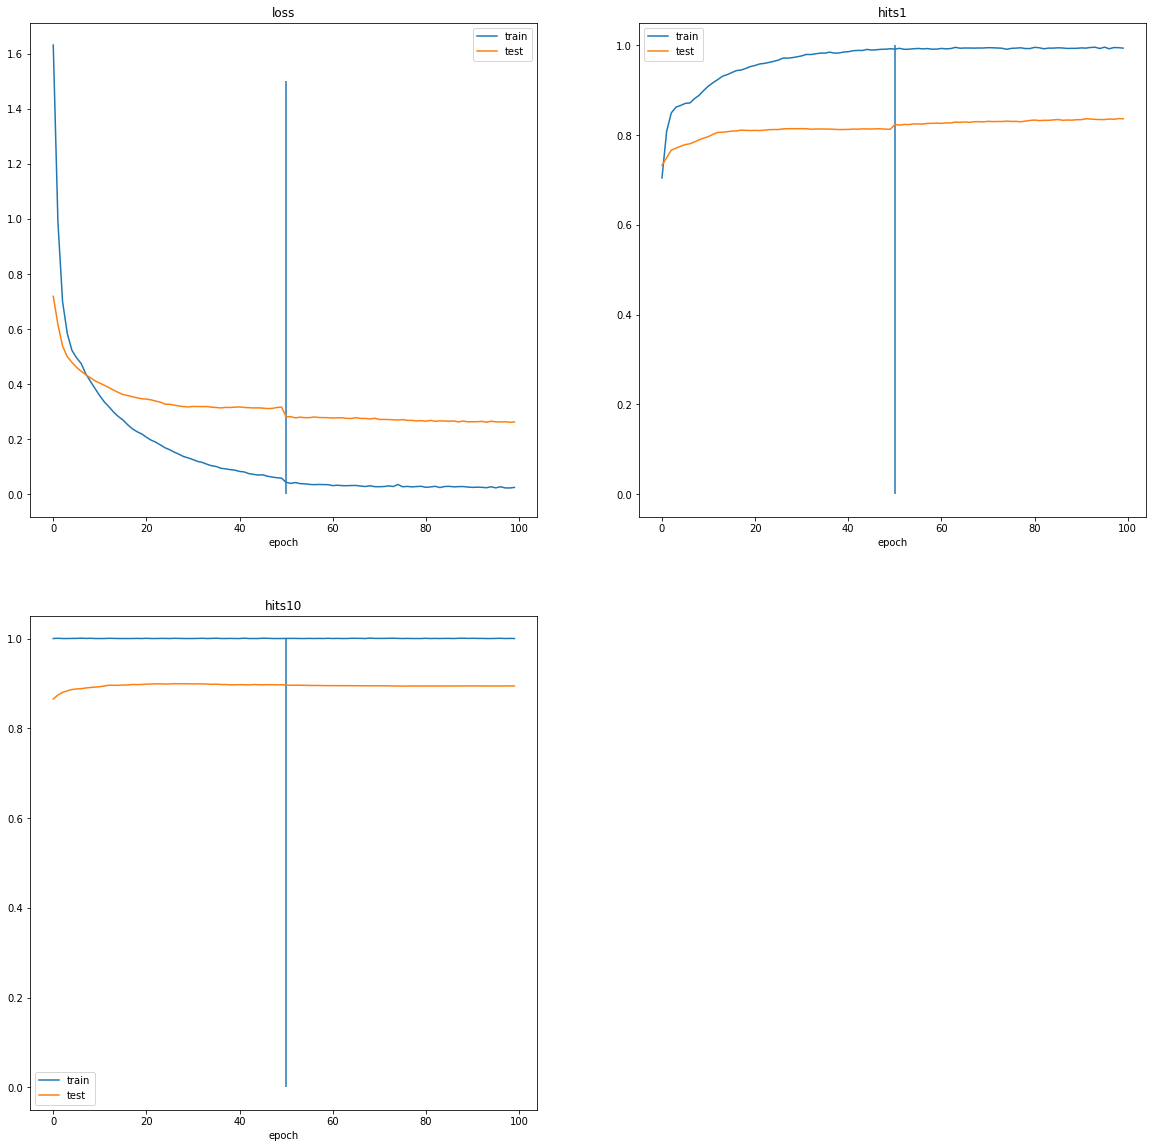

In [100]:
plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
plt.plot(loss_history_train, label='train')
plt.plot(loss_history_test, label='test')
plt.title('loss')
plt.xlabel('epoch')
plt.vlines(50, 0, 1.5)
plt.legend()



plt.subplot(2, 2, 2)
plt.plot(hits1_history_train, label='train')
plt.plot(hits1_history_test, label='test')
plt.title('hits1')
plt.xlabel('epoch')
plt.vlines(50, 0, 1)
# plt.ylim(0.1, 0.87)
plt.legend()



plt.subplot(2, 2, 3)
plt.plot(hits10_history_train, label='train')
plt.plot(hits10_history_test, label='test')
plt.title('hits10')
plt.xlabel('epoch')
plt.vlines(50, 0, 1)
plt.legend()

plt.show()